# Second Test

Very simple 1D model to try the integration of empymod into SimPEG.

**Limitations at this point:**

- Frequency domain (for the time-domain we will need some scripts to convert the data into the frequency domain, and then run the frequency domain inversion)
- Inversion only for resistivity ($\rho_h$), hence fixed values for anisotropy ($\lambda$), electric permeabilities ($\epsilon_h$, $\epsilon_v$) and magnetic permeabilities ($\mu_h$, $\mu_v$)
- Fixed depth structure (only inverting for layer thicknesses)
- No `numexpr`
- Numerical derivatives.

**Things to discuss**
- Allow to invert for either or jointly several of $\rho_h, \rho_v, \varepsilon_h, \varepsilon_v, \mu_h, \mu_v; z$
- Weighting
- Penalty
- Fixed Layers
- Boundaries
- Starting model: use best fitting halfspace
- Invert using Real/Imaginary or Amplitude/Phase

**Other considerations**

- SimPEG supports, I think, Python 2.7 and 3+, however, empymod only supports Python 3.4 upwards.

In [1]:
# I was playing around with this on Azure, so needed the install step
# !pip install SimPEG
# !pip install empymod

In [2]:
import numpy as np
from scipy import optimize
from copy import deepcopy as dc
import matplotlib.pyplot as plt
from scipy.constants import mu_0, epsilon_0

import SimPEG
import empymod
from empymod import utils

## 1. Forward model, create data


### 1.1 Define model and create data

Define all data as required by `empymod.bipole`, except the time-domain arguments (`freq` instead `freqtime`; `signal`, `ft`, `ftarg`).

In [3]:
depth = np.array([ -np.infty, 0, 1000, 1600, 1900]) # Layer boundaries
res = np.array([2e14, .3, 1, 100, 1])    # Air, sea, overburden, target, underburden
freq = np.array([0.01, 0.1, 1.])         # 0.01, 0.1 & 1 Hz
sx = np.array([0, 500])                  # Source x-points
src = [sx, sx*0, 900, 0, 0]              # Src coordinates
x = np.arange(2, 6)*1000                 # Receiver x-points
rec = [x, x*0, 1000, 0, 0]               # Rec coordinates

### 1.2 Define a new `bipole`-routine

Simplified, just for the calculation, without tests.

In [4]:
def bipole(src, rec, depth, freq, etaH, etaV, zetaH, zetaV, msrc, srcpts, mrec,
           recpts, strength, xdirect, ht, htarg, nrec, nsrc, nsrcz, srcdipole,
           nrecz, recdipole, isrz, isrc, irec, isfullspace, use_spline,
           use_ne_eval, loop_freq, loop_off):

    verb = 1

    # Pre-allocate output EM array
    EM = np.zeros((freq.size, nrec*nsrc), dtype=complex)

    # Initialize kernel count, conv (only for QWE)
    # (how many times the wavenumber-domain kernel was calld)
    kcount = 0
    conv = True

    # The kernel handles only 1 ab with one srcz-recz combination at once.
    # Hence we have to loop over every different depth of src or rec, and
    # over all required ab's.
    for isz in range(nsrcz):  # Loop over source depths

        # Get this source
        srcazmdip = utils.get_azm_dip(src, isz, nsrcz, srcpts, srcdipole, strength, 'src', verb)
        tsrc, srcazm, srcdip, srcg_w, srcpts, src_w = srcazmdip

        for irz in range(nrecz):  # Loop over receiver depths

            # Get this receiver
            recazmdip = utils.get_azm_dip(rec, irz, nrecz, recpts, recdipole, strength, 'rec', verb)
            trec, recazm, recdip, recg_w, recpts, rec_w = recazmdip

            # Get required ab's
            ab_calc = utils.get_abs(msrc, mrec, srcazm, srcdip, recazm, recdip, verb)

            # Pre-allocate temporary source-EM array for integration loop
            sEM = np.zeros((freq.size, isrz), dtype=complex)

            for isg in range(srcpts):  # Loop over src integration points

                # This integration source
                tisrc = [tsrc[0][isg::srcpts], tsrc[1][isg::srcpts], tsrc[2][isg]]

                # Get layer number in which src resides
                lsrc, zsrc = utils.get_layer_nr(tisrc, depth)

                # Pre-allocate temporary receiver EM arrays for integr. loop
                rEM = np.zeros((freq.size, isrz), dtype=complex)

                for irg in range(recpts):  # Loop over rec integration pts
                    # Note, if source or receiver is a bipole, but horizontal
                    # (dip=0), then calculation could be sped up by not looping
                    # over the bipole elements, but calculate it all in one go.

                    # This integration receiver
                    tirec = [trec[0][irg::recpts], trec[1][irg::recpts], trec[2][irg]]

                    # Get src-rec offsets and angles
                    off, angle = utils.get_off_ang(tisrc, tirec, isrc, irec, verb)

                    # Get layer number in which rec resides
                    lrec, zrec = utils.get_layer_nr(tirec, depth)

                    # Gather variables
                    finp = (off, angle, zsrc, zrec, lsrc, lrec, depth, freq,
                            etaH, etaV, zetaH, zetaV, xdirect, isfullspace, ht,
                            htarg, use_spline, use_ne_eval, msrc, mrec,
                            loop_freq, loop_off, conv)

                    # Pre-allocate temporary EM array for ab-loop
                    abEM = np.zeros((freq.size, isrz), dtype=complex)

                    for iab in ab_calc:  # Loop over required ab's

                        # Carry-out the frequency-domain calculation
                        out = empymod.model.fem(iab, *finp)

                        # Get geometrical scaling factor
                        tfact = utils.get_geo_fact(iab, srcazm, srcdip, recazm, recdip, msrc, mrec)

                        # Add field to EM with geometrical factor
                        abEM += out[0]*np.squeeze(tfact)

                        # Update kernel count
                        kcount += out[1]

                        # Update conv (QWE convergence)
                        conv *= out[2]

                    # Add this receiver element, with weight from integration
                    rEM += abEM*recg_w[irg]

                # Add this source element, with weight from integration
                sEM += rEM*srcg_w[isg]

            # Get required [s]tart- and [e]nd-[i]ndices, and [st]ep
            if nrec == nrecz:
                if nsrc == nsrcz:  # Case 1: Looped over each src and each rec
                    si = isz*nrec + irz
                    ei = si + 1
                    st = 1
                else:              # Case 2: Looped over each rec
                    si = irz
                    ei = nsrc*nrec
                    st = nrec
            else:
                if nsrc == nsrcz:  # Case 3: Looped over each src
                    si = isz*nrec
                    ei = si + nrec
                    st = 1
                else:              # Case 4: All in one go
                    si = 0
                    ei = nsrc*nrec
                    st = 1

            # Get required scaling from src-strength and src/rec-length
            src_rec_w = 1
            if strength > 0:
                src_rec_w *= np.repeat(src_w, irec)
                src_rec_w *= np.tile(rec_w, isrc)

            # Add this src-rec signal
            EM[:, si:ei:st] = sEM*src_rec_w

    # In case of QWE/QUAD, print Warning if not converged
    utils.conv_warning(conv, htarg, 'Hankel', verb)

    return np.ravel(EM, order='F')

### 1.3 Create data and add noise

Add 5 % random noise and a noise level of 10e-15 V/m.

In [5]:
# Data
data = empymod.bipole(src, rec, depth, res, freq)

# Generate noise
mask = 5e-2*(1.5 - np.random.random_sample(data.shape))
maskn = 1e-15*(1.5 - np.random.random_sample(data.shape))

# Apply noise
data = data*(1 + mask) + maskn

# Lets also calculate a denser model
xf = np.arange(26, 106)*50       # Offsets
full = empymod.bipole([sx[0], sx[0], src[2], src[3], src[4]], [xf, xf*0, rec[2], rec[3], rec[4]], depth, res, freq)

# Ensure dimensionality, because empymod.dipole squeezes the output
if len(freq) == 1:
    data = data[None, :]
    full = full[None, :]


:: empymod END; runtime = 0:00:00.031758 :: 1 kernel call(s)


:: empymod END; runtime = 0:00:00.214962 :: 1 kernel call(s)



### 1.4 Define plot function and plot model and data

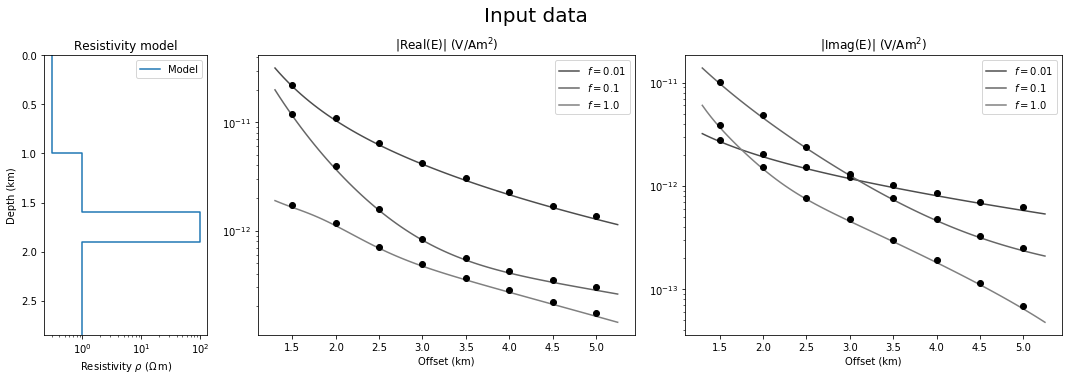

In [6]:
# Define offset; this has to be adjusted depending on the model!
off = np.array([])
for _, val in enumerate(sx):
    off = np.r_[off, x-val]

def plot_data(title, res, idata=None):
    # Create figure
    fig = plt.figure(figsize=(15, 5))
    plt.suptitle(title, y=1.05, fontsize=20)

    # Plot Resistivity Model
    ax0 = plt.subplot(151)
    plt.title('Resistivity model')
    plt.ylabel('Depth (km)')
    plt.xlabel(r'Resistivity $\rho\ (\Omega\,\rm{m})$')
    plt.xscale('log')
    plt.ylim([1.5*depth[-1]/1000, 0])
    
    for key, value in res.items():
        plt.plot(np.repeat(value[1][1:], 2),
                 np.r_[np.repeat(value[0][1:], 2), 1.5*value[0][-1]][1:]/1000,
                 label=key)
    plt.legend()


    # Define real subplot
    ax1 = plt.subplot2grid((1, 5), (0, 1), colspan=2)
    plt.title(r'|Real(E)| (V/Am$^2$)')
    plt.xlabel('Offset (km)')

    # Define imaginary subplot
    ax2 = plt.subplot2grid((1, 5), (0, 3), colspan=2)
    plt.title(r'|Imag(E)| (V/Am$^2$)')
    plt.xlabel('Offset (km)')

    # Loop over real, imaginary subplots
    for t, ax in enumerate([ax1, ax2]):
        # Get type
        ri_type = (np.real, np.imag)[t]

        # Activate required subplot
        plt.sca(ax)

        # Loop over frequencies
        for i, f in enumerate(freq):
            # Plot True model
            plt.semilogy(xf/1000, np.abs(ri_type(full[i, :])), str(0.3+i*0.1), label='$f=$'+str(f))

            # Plot data
            plt.semilogy(off/1000, np.abs(ri_type(data[i, :].ravel('F'))), 'ko')

            # Plot inversion result
            if np.any(idata):
                plt.semilogy(off/1000, np.abs(ri_type(idata[i, :].ravel('F'))), 'd')

        # Legend
        plt.legend(loc='best')

    plt.tight_layout()
    plt.show()
    
# Plot Model and input data
plot_data('Input data', {'Model': (depth, res)})

## 2. SimPEG wrapper class for an empymod problem

In [7]:
# this is sketching out an idea for later... we can chat! 

# import properties

# class EmpymodParameters(properties.HasProperties):
    
#     zsrc = properties.Array("z location of the source", default=np.r_[10])

In [8]:
# Do the checks, that empymod.bipole usually does. These should potentially go into __init__.

# Check src and rec, get flags if dipole or not
# nsrcz/nrecz are number of unique src/rec-pole depths
src, nsrc, nsrcz, srcdipole = utils.check_bipole(src, 'src')
rec, nrec, nrecz, recdipole = utils.check_bipole(rec, 'rec')

# Define some indeces
isrc = int(nsrc/nsrcz)  # this is either 1 or nsrc
irec = int(nrec/nrecz)  # this is either 1 or nrec
isrz = int(isrc*irec)   # this is either 1, nsrc, nrec, or nsrc*nrec

In [9]:
from SimPEG.Problem import BaseProblem
from SimPEG import Props

class EmpymodProblem(BaseProblem):
    """
    Problem class for a simulation conducted with empymod
    """
    
    rho, rho_map, rho_deriv = Props.Invertible(
        "Electrical Resistivity (Ohm m)"
    ) 
    
    deleteTheseOnModelUpdate = ['_Japprox']
    
    # Stuff we don't touch at the moment and keep fixed
    empymod_settings = {
        'isfullspace': False,
        'xdirect': False,
        'ht': 'fht',
        'htarg': (empymod.filters.key_201_2009(), None),
        'use_spline': True,
        'use_ne_eval': False,
        'loop_freq': True,
        'loop_off': False,
        'srcpts': 1,
        'recpts': 1,
    }
        
    def __init__(self, mesh, **kwargs):
        assert mesh.dim == 1, "only 1D modelling supported"
        super(EmpymodProblem, self).__init__(mesh, **kwargs)
        
        # Set air at infinity
        depth = self.mesh.gridN.copy()
        
        # set the empymod_fixedparams
        zeta = np.outer(2j*np.pi*freq, np.ones(depth.shape)*mu_0)
        
        # Set the empymod_fixedparams
        # Most of this was defined in point 1.2
        self.fixed_params = {
            'src': src,
            'rec': rec,
            'nsrc': nsrc,
            'nrec': nrec,
            'nsrcz': nsrcz,
            'nrecz': nrecz,
            'srcdipole': srcdipole,
            'recdipole': recdipole,
            'isrc': isrc,
            'irec': irec,
            'isrz': isrz,
            'depth': depth,
            'freq': freq,
            'zetaH': zeta,
            'zetaV': zeta,
            'msrc': False,
            'mrec': False,
            'strength': 0,
        }
               
    def _calc_fm(self, rho):
        """
        compute data using empymod. The real and imaginary parts are separated so that 
        we are always working with real values
        """
        
        # Calculate eta (isotropic)
        eta = 1/rho + np.outer(2j*np.pi*freq, np.ones(rho.shape)*epsilon_0)
        
        # Calculate result
        out = bipole(etaH=eta, etaV=eta, **self.fixed_params, **self.empymod_settings)

        return np.hstack([out.real, out.imag])
    
    def fields(self, m):
        """
        Computes the fields
        """
        
        # set the model (this performs the mappings)
        self.model = m
        return self._calc_fm(self.rho)
    
    def Japprox(self, m, perturbation=0.1, min_perturbation=1e-3):
        """
        Approximate sensitivity computed using a finite difference approach
        """
        if getattr(self, '_Japprox', None) is None:
            self.model = m 
            delta_m = min_perturbation # np.max([perturbation*m.mean(), min_perturbation])

            J = []

            for i, entry in enumerate(m):
                mpos = m.copy()
                mpos[i] = entry + delta_m
                
                mneg = m.copy()
                mneg[i] = entry - delta_m
                
                pos = self._calc_fm(self.rho_map * mpos)
                neg = self._calc_fm(self.rho_map * mneg)
                J.append((pos - neg) / (2.*delta_m))

            self._Japprox = np.vstack(J).T
            
        return self._Japprox
    
    def Jvec(self, m, v, f=None):
        """
        Sensitivity times a vector
        """
        self.model = m
        return self.Japprox(m).dot(v)

    def Jtvec(self, m, v, f=None):
        """
        Adjoint Sensitivity times a vector
        """
        self.model = m
        return self.Japprox(m).T.dot(v)

    
class EmpymodSurvey(SimPEG.Survey.BaseSurvey):
    """
    Survey class for a simulation conducted with empymod
    """
    
    @property 
    def nD(self):
        # this will likely need to be generalized
        return self.prob.fixed_params['nsrc'] * self.prob.fixed_params['nrec'] * len(self.prob.fixed_params['freq']) * 2
        
    def eval(self, f):
        return f

def re_field(inp):
    inp = inp.reshape(2, -1)
    inp = inp[0, :] + 1j*inp[1, :]
    return inp.reshape((-1, nrec, nsrc), order='F')

## Tests
- **forward** make sure we can reproduce initial results
- **Jvec** test sensitivity computation

In [10]:
# this is something we can work on cleaning up - simpeg needs a mesh for the forward problem,
# working with infinity is tricky, so I make it finite here and swap it out for an inf in 
# the instantiation of the problem 

finite_air_z = 1000
true_depth = depth[1:].copy()
true_depth = np.hstack([np.r_[-finite_air_z], true_depth])
meshfwd = SimPEG.Mesh.TensorMesh([np.diff(true_depth)], x0=[-finite_air_z])

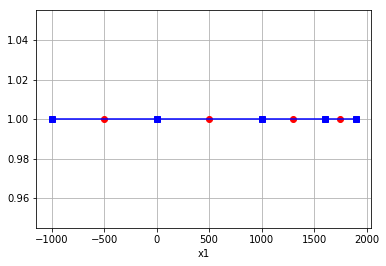

In [11]:
# plot the mesh
meshfwd.plotGrid(nodes=True, centers=True)

Here, we set up mappings - we will invert for log(resistivity) below the sea floor

In [12]:
# for the inversion, we want to ignore air and probably the sea layers
# and invert for log-resistivity 

exp_map_fwd = SimPEG.Maps.ExpMap(nP=len(res))
inject_active_cells_fwd = SimPEG.Maps.InjectActiveCells(
    meshfwd, 
    np.arange(2, len(res)),  # active indices (eg layers we want to invert for)
    np.log(res[:2]),  # log-resistivity values of the inactive cells
    nC=len(res)
)

In [13]:
# create the problem object
probfwd = EmpymodProblem(meshfwd, rho_map=exp_map_fwd * inject_active_cells_fwd)

In [14]:
# start with the true model and compute data 

m = np.log(res[2:])
fields = probfwd.fields(m)

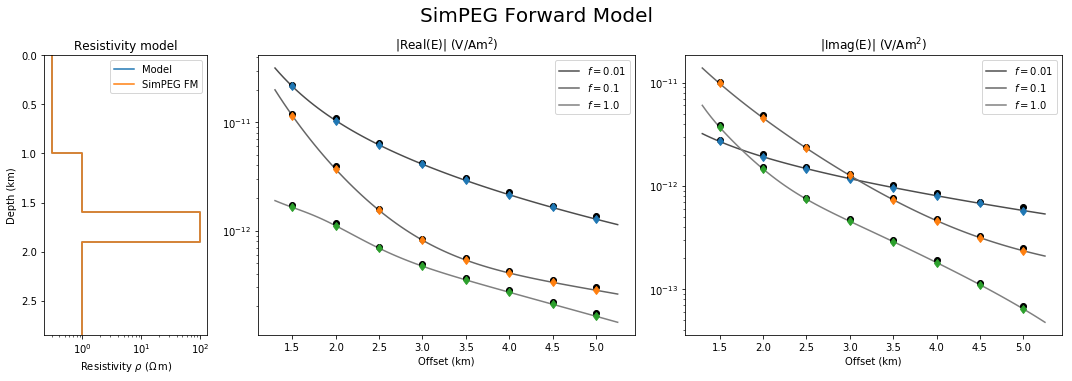

In [15]:
plot_data('SimPEG Forward Model', {'Model': (depth, res), 'SimPEG FM': (depth, probfwd.rho)}, (re_field(fields)))

## Test the sensitivities

Work with a 20 layer model, check that the sensitivities are second order

In [16]:
from SimPEG import Tests

In [17]:
finite_air_z = 1000
seafloor = depth[2]
nlayers = 20
last_layer = 2500  # depth of last layer

h = (last_layer-seafloor)/nlayers  # layer thicknesses

# create a mesh
inversion_depths = np.hstack([
    np.r_[-finite_air_z, 0.], 
    np.arange(seafloor, last_layer+h, h)
])

simpeg_depths = np.diff(inversion_depths)
mesh = SimPEG.Mesh.TensorMesh([simpeg_depths], x0=[-finite_air_z])

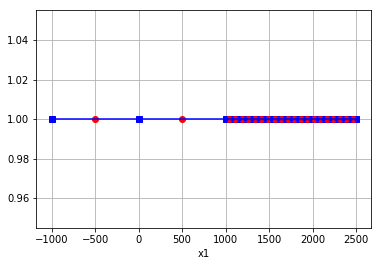

In [18]:
mesh.plotGrid(nodes=True, centers=True)

In [19]:
# mappings and problem 

exp_map = SimPEG.Maps.ExpMap(nP=nlayers+3)
inject_active_cells = SimPEG.Maps.InjectActiveCells(
    mesh, 
    2+np.arange(0, nlayers+1),  # active indices (eg layers we want to invert for)
    np.log(res[:2]),  # log-resistivity values of the inactive cells
    nC=nlayers+3
)

prob = EmpymodProblem(mesh, rho_map=exp_map * inject_active_cells)

In [20]:
# m0 = np.random.rand(nlayers+1)
m0 = np.zeros(nlayers+1)
def function_and_deriv(x):   
    return prob.fields(x), lambda v: prob.Jvec(m0, v)

==================== checkDerivative ====================
iter    h         |ft-f0|   |ft-f0-h*J0*dx|  Order
---------------------------------------------------------
 0   1.00e-01    4.487e-13     3.829e-14      nan
 1   1.00e-02    4.223e-14     3.619e-16      2.024
 2   1.00e-03    4.199e-15     3.599e-18      2.002
 3   1.00e-04    4.196e-16     3.592e-20      2.001
 4   1.00e-05    4.196e-17     3.549e-22      2.005
 5   1.00e-06    4.196e-18     3.377e-24      2.022
========================= PASS! =========================
That was easy!



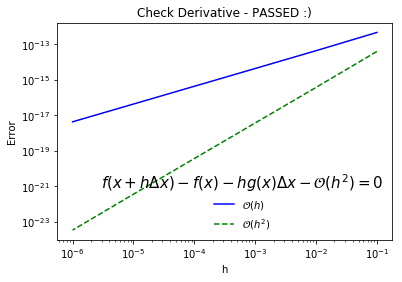

True

In [21]:
Tests.checkDerivative(function_and_deriv, x0=m0, num=6, expectedOrder=2)

In [22]:
# Test Adjoint
u = prob.fields(m0)

v = np.random.rand(len(u))
w = np.random.rand(len(m0))

vJw = v.dot(prob.Jvec(m0, w))
wJtv = w.dot(prob.Jtvec(m0, v))

print(vJw, wJtv, vJw - wJtv)

3.51336410477e-12 3.51336410477e-12 -4.03896783473e-28


## Invert 

- Use a 20 layer model, starting model and reference model of log(1 Ohm m) 
- we will invert the clean data for now
- assign a 5% error and a 5e-15 floor so that we don't over-fit the zero-crossings

In [23]:
survey = EmpymodSurvey()
survey.pair(prob)

In [24]:
rdata = np.ravel(data, order='F')
survey.dobs = np.hstack([rdata.real, rdata.imag])  # observed data
survey.std = np.abs(survey.dobs)*.05
survey.eps = 5e-15

In [25]:
# regularization
reg = SimPEG.Regularization.Simple(
    SimPEG.Mesh.TensorMesh([len(m0)]), alpha_s=5e-5, alpha_x=1, mref=np.zeros(nlayers+1)
)

# data misfit
dmis = SimPEG.DataMisfit.l2_DataMisfit(survey)

# optimization
opt = SimPEG.Optimization.InexactGaussNewton(maxIter=40)

# inverse problem
invProb = SimPEG.InvProblem.BaseInvProblem(dmis, reg, opt, beta=5)

# directives 
target = SimPEG.Directives.TargetMisfit()
directives = [
#     SimPEG.Directives.BetaEstimate_ByEig(beta0_ratio=5e-2),
    target
]

# inversion
inv = SimPEG.Inversion.BaseInversion(invProb, directiveList=directives)

In [26]:
m0 = np.zeros(nlayers+1) # starting model

In [27]:
# run the inversion 
mrec = inv.run(m0)


    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  5.00e+00  3.41e+03  0.00e+00  3.41e+03    7.87e+02      0              
   1  5.00e+00  2.40e+03  1.47e-04  2.40e+03    2.71e+02      0              
   2  5.00e+00  1.41e+03  6.84e-01  1.41e+03    7.01e+02      0              
   3  5.00e+00  1.20e+03  9.18e+00  1.24e+03    1.37e+03      0   Skip BFGS  
   4  5.00e+00  7.67e+02  7.88e+00  8.07e+02    8.60e+02      1              
   5  5.00e+00  6.37e+02  5.19e+00  6.63e+02    7.39e+02      0              
   6  5.00e+00  2.03e+02  6.05e+00  2.33e+02    4.21e+02      0              
   7  5.00e+00  1.73e+02  5.07e+00  1.99e+

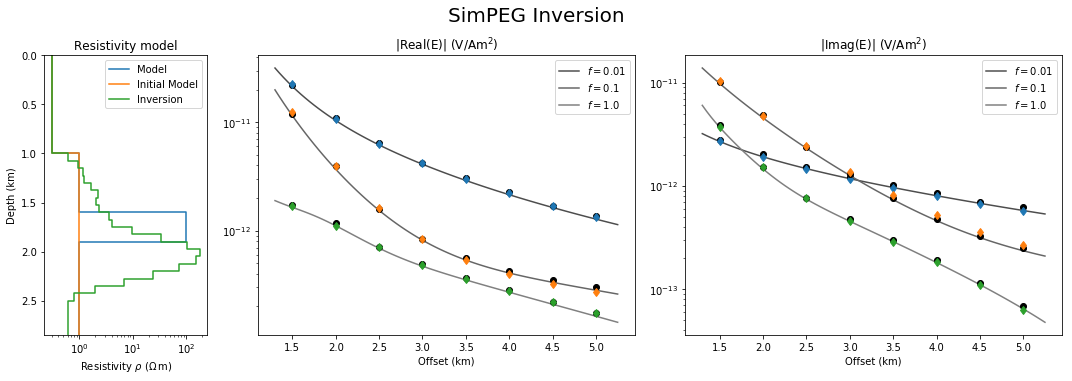

In [28]:
plot_data('SimPEG Inversion',
          {'Model': (depth, res),
           'Initial Model': (mesh.gridN, prob.rho_map*m0),
           'Inversion': (mesh.gridN, prob.rho_map*mrec)},
          (re_field(prob.fields(mrec))))

In [29]:
import printinfo
printinfo.info()